# Leaf Disease Detection

This project implements **two different deep learning approaches** for image classification:

1. **CNN Model** – Built from scratch with multiple convolutional and pooling layers.  
2. **VGG16 Transfer Learning Model** – A pre-trained model fine-tuned on our dataset.

###  Dataset
- Custom dataset organized in subfolders for each class.
- Images are resized to **64×64** pixels.
- Training and testing splits handled automatically with `ImageDataGenerator`.

###  Model Performance
| Model                  | Training Accuracy |
|------------------------|-------------------|
| CNN                    | **92%**           |
| VGG16 (Transfer Learn) | **72%**           |

The **CNN** outperformed VGG16 on this dataset, likely due to its simpler architecture being more suited to the dataset size and characteristics.

### Tools & Libraries Used
- **Keras 2.3.1**
- **TensorFlow 1.14.0**
- **NumPy 1.19.2**
- **Matplotlib 3.1.1**
- **Pillow 9.5.0**

###  Key Steps in the Workflow
1. **Data Loading & Preprocessing** – Reading, resizing, and normalizing images.
2. **Model Training** – Training both CNN and VGG16 models.
3. **Performance Visualization** – Plotting training accuracy and loss curves.
4. **Image Prediction** – Testing models on unseen images.
5. **Model Saving** – Storing weights, architecture, and training history for reuse.

✅ This notebook clearly demonstrates **model building, training, evaluation, and prediction** in a clean, modular way.


###  Step 1: Import Required Libraries

In [1]:
import os
import keras
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import to_categorical
from keras.layers import MaxPooling2D, Dense, Dropout, Flatten, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras import applications
from keras.layers import Input
import warnings

warnings.filterwarnings('ignore')

# Globals
load_model = 0
normal_accuracy = 0
vgg_accuracy = 0

Using TensorFlow backend.
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

### Step 2: Define Plant Disease Classes & Helper Functions
We list the target classes (types of rice leaf conditions) and prepare:
- A list to hold class labels
- A helper function `getID()` that maps class names to integer IDs.

In [2]:
plants = ['Brownspot', 'Healthy', 'Leafblast', 'Leafblight']
path = 'Dataset'

labels = []
X_train = []
Y_train = []

def getID(name):
    """Return numeric ID for a given label name."""
    for i, label in enumerate(labels):
        if label == name:
            return i
    return 0

### Step 3: Load Dataset and Extract Class Labels
We walk through the dataset directory to:
- Identify all class folder names
- Append them to our `labels` list for later use.

In [3]:
for root, dirs, files in os.walk(path):
    for file in files:
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)

print("Labels found in dataset:", labels)


Labels found in dataset: ['Brownspot', 'Healthy', 'Leafblast', 'Leafblight']


### Step 4: Load and Preprocess Images
For every image in the dataset:
- Read using OpenCV
- Resize to 64x64 pixels
- Convert to a NumPy array
- Assign the correct label ID
- Normalize pixel values to the range [0, 1]


In [4]:
X_train, Y_train = [], []

# Walk through dataset folders
for root, dirs, files in os.walk(path):
    for file_name in files:
        name = os.path.basename(root)  # Class name
        print(f"{name} {os.path.join(root, file_name)}")

        # Skip unwanted files
        if 'Thumbs.db' not in file_name:
            img_path = os.path.join(root, file_name)

            # Open image with Pillow
            img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
            img = img.resize((64, 64))  # Resize to 64x64

            # Convert to NumPy array
            im2arr = np.array(img)
            X_train.append(im2arr)
            Y_train.append(getID(name))

# Convert lists to NumPy arrays
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

print(Y_train)


Brownspot Dataset\Brownspot\DSC_0100.jpg
Brownspot Dataset\Brownspot\DSC_0101.jpg
Brownspot Dataset\Brownspot\DSC_0104.jpg
Brownspot Dataset\Brownspot\DSC_0105.jpg
Brownspot Dataset\Brownspot\DSC_0106.jpg
Brownspot Dataset\Brownspot\DSC_0107.jpg
Brownspot Dataset\Brownspot\DSC_0108.jpg
Brownspot Dataset\Brownspot\DSC_0109.jpg
Brownspot Dataset\Brownspot\DSC_0110.jpg
Brownspot Dataset\Brownspot\DSC_0111.jpg
Brownspot Dataset\Brownspot\DSC_0112.jpg
Brownspot Dataset\Brownspot\DSC_0113.jpg
Brownspot Dataset\Brownspot\DSC_0114.jpg
Brownspot Dataset\Brownspot\DSC_0115.jpg
Brownspot Dataset\Brownspot\DSC_0116.jpg
Brownspot Dataset\Brownspot\DSC_0117.jpg
Brownspot Dataset\Brownspot\DSC_0118.jpg
Brownspot Dataset\Brownspot\DSC_0119.jpg
Brownspot Dataset\Brownspot\DSC_0121.jpg
Brownspot Dataset\Brownspot\DSC_0292.JPG
Brownspot Dataset\Brownspot\DSC_0295.JPG
Brownspot Dataset\Brownspot\DSC_0296.jpg
Brownspot Dataset\Brownspot\DSC_0299.JPG
Brownspot Dataset\Brownspot\DSC_0300.JPG
Brownspot Datase

### Step 5: Shuffle and Save Preprocessed Data
- Randomly shuffle dataset to avoid training order bias
- Convert labels to one-hot encoded vectors
- Save processed data to disk (`model/X.txt` and `model/Y.txt`)


In [5]:
# Shuffle dataset
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
Y_train = to_categorical(Y_train[indices])  # One-hot encode labels

# Create model directory if not exists
os.makedirs('model', exist_ok=True)

# Save preprocessed dataset
np.save('model/X.npy', X_train)
np.save('model/Y.npy', Y_train)

# Reload to verify integrity
X_train = np.load('model/X.npy')
Y_train = np.load('model/Y.npy')

print("Dataset shapes:", X_train.shape, Y_train.shape)

Dataset shapes: (160, 64, 64, 3) (160, 4)


### Step 6: Build and Train CNN Model (or Load Existing One)
We either:
1. Load a saved model and weights from `model/normal_model.json` & `.h5`
2. Or build a new Convolutional Neural Network:
    - Two convolution + pooling layers
    - One dense hidden layer
    - Output layer with 4 neurons (one per class)
We then save the trained model and its training history.

In [6]:
# Check if a saved model exists
if os.path.exists('model/normal_model.json'):
    # Load existing model
    with open('model/normal_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        classifier = model_from_json(loaded_model_json)

    # Load model weights
    classifier.load_weights("model/normal_weights.h5")
    cnn_model = classifier

    # Print model summary
    print("Loaded existing model:")
    print(classifier.summary())

    # Load training history
    with open('model/normal_history.pckl', 'rb') as f:
        history_data = pickle.load(f)

    final_accuracy = history_data['accuracy'][-1] * 100
    print(f"CNN Training Accuracy = {final_accuracy:.2f}%")

else:
    # Build new CNN model
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(256, activation='relu'))
    classifier.add(Dense(4, activation='softmax'))  # 4 output classes

    # Print model architecture
    print("Created new CNN model:")
    print(classifier.summary())

    # Compile the model
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    hist = classifier.fit(X_train, Y_train, batch_size=16, epochs=10, shuffle=True, verbose=2)

    # Save model weights and architecture
    os.makedirs('model', exist_ok=True)
    classifier.save_weights('model/normal_weights.h5')
    cnn_model = classifier
    with open("model/normal_model.json", "w") as json_file:
        json_file.write(classifier.to_json())

    # Save training history
    with open('model/normal_history.pckl', 'wb') as f:
        pickle.dump(hist.history, f)

    # Assign to common variable for plotting
    history_data = hist.history

    # Print final training accuracy
    final_accuracy = history_data['accuracy'][-1] * 100
    print(f"Final Training Accuracy = {final_accuracy:.2f}%")


Loaded existing model:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dense_2 (Dense)              (

### Step 7: CNN Training Accuracy & Loss Visualization

This graph shows how the **training accuracy** (green) and **training loss** (red) change over each epoch during the CNN model training.  
- **Accuracy (green)** → Measures how well the model predicts correctly on the training dataset.  
- **Loss (red)** → Represents the error between the predicted and actual labels; lower is better.  

By plotting both in the same graph, we can easily observe:
- Whether accuracy is improving steadily.
- Whether loss is decreasing consistently.
- Signs of overfitting (if loss stops decreasing while accuracy increases).

The goal is to see **accuracy go up** while **loss goes down** over epochs.


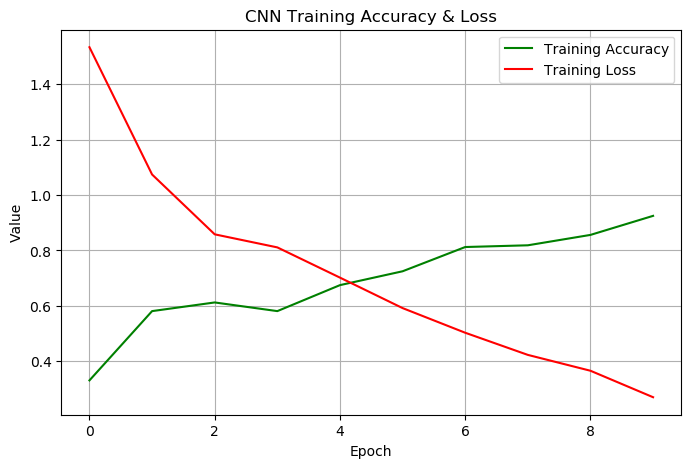

In [7]:
#CNN Training Accuracy (green) & Training Loss (red)
plt.figure(figsize=(8, 5))
plt.plot(history_data['accuracy'], color='green', label='Training Accuracy')
plt.plot(history_data['loss'], color='red', label='Training Loss')
plt.title('CNN Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


### Step 8: Transfer Learning using VGG16
We leverage a pre-trained VGG16 model:
- Remove its fully connected top layers
- Add custom convolution, pooling, dense, and dropout layers
- Freeze first 7 layers to preserve learned features
- Train on our dataset using image augmentation
- Save the trained weights and model


In [8]:
os.makedirs('model', exist_ok=True)
# Check if a saved VGG model exists
if os.path.exists('model/vgg_model.json'):
   
    # Load the existing model
    with open('model/vgg_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        classifier = model_from_json(loaded_model_json)

    # Load weights
    classifier.load_weights("model/vgg_weights.h5")
    loaded_model = classifier

    # Print summary
    print("Loaded existing VGG16 model with transfer learning:")
    print(classifier.summary())

    # Load training history
    with open('model/vgg_history.pckl', 'rb') as f:
        history_data = pickle.load(f)

    final_accuracy = history_data['accuracy'][-1] * 100
    print(f"VGG16 Training Accuracy (last epoch) = {final_accuracy:.2f}%")

else:
    # Build new VGG16 model
    input_tensor = Input(shape=(64, 64, 3))
    vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Use block2_pool as base and add custom layers
    x = vgg_model.get_layer('block2_pool').output
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='softmax')(x)

    # Create custom model
    custom_model = Model(inputs=vgg_model.input, outputs=x)

    # Freeze first 7 layers
    for layer in custom_model.layers[:7]:
        layer.trainable = False

    # Compile model
    custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Data augmentation for training, simple rescaling for testing
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.)

    # Create data generators
    training_set = train_datagen.flow_from_directory(
        'Dataset', target_size=(64, 64), batch_size=2,
        class_mode='categorical', shuffle=True
    )
    test_set = test_datagen.flow_from_directory(
        'Dataset', target_size=(64, 64), batch_size=2,
        class_mode='categorical', shuffle=False
    )

    # Train the model
    hist = custom_model.fit(
        training_set,
        steps_per_epoch=500,
        epochs=10,
        validation_data=test_set,
        validation_steps=125
    )

    # Save model architecture and weights
    custom_model.save_weights('model/vgg_weights.h5')
    with open("model/vgg_model.json", "w") as json_file:
        json_file.write(custom_model.to_json())

    loaded_model = custom_model

    # Save training history
    with open('model/vgg_history.pckl', 'wb') as f:
        pickle.dump(hist.history, f)

    # Store history for plotting
    history_data = hist.history

    # Print final training accuracy
    final_accuracy = history_data['accuracy'][-1] * 100
    print(f"Final VGG16 Training Accuracy = {final_accuracy:.2f}%")

Loaded existing VGG16 model with transfer learning:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_

### Step 9: VGG16 Training Accuracy & Loss Visualization

This chart displays the **training accuracy** (green) and **training loss** (red) for the VGG16-based model during training.

- **Accuracy (green)** → Shows the percentage of correctly classified samples on the training set.  
- **Loss (red)** → Indicates the model's prediction error; lower values are better.  

By plotting them together, we can see:
- How well the model is learning over time.
- Whether the loss is decreasing while accuracy improves.
- Any signs of slow learning or underfitting, which may suggest the need for:
  - More training epochs
  - Unfreezing additional VGG16 layers for fine-tuning
  - Using higher-resolution input images (e.g., 128×128 or 224×224)

In this project, VGG16 achieved **~72% training accuracy**, which is lower than the custom CNN model (~92%), possibly due to limited fine-tuning and smaller input image size.


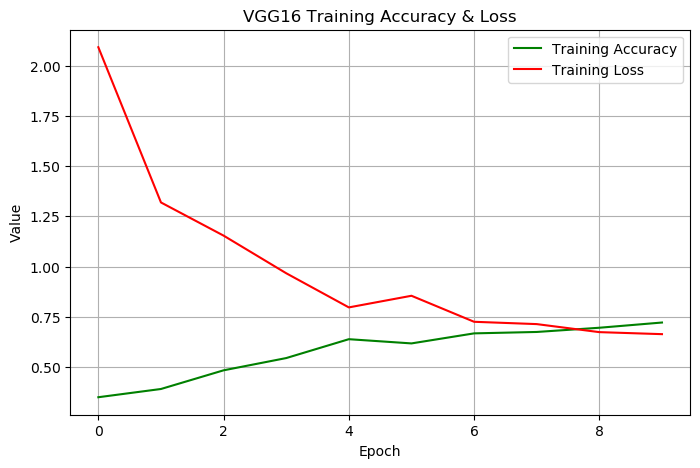

In [9]:
# VGG16 Training Accuracy (green) & Training Loss (red)
plt.figure(figsize=(8, 5))
plt.plot(history_data['accuracy'], color='green', label='Training Accuracy')
plt.plot(history_data['loss'], color='red', label='Training Loss')
plt.title('VGG16 Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


### Step 10: Make Predictions
We load the trained model and classify a new image into one of the four categories.

In [10]:
def predict_image(image_path, model):
    """Predict the class of an image and display it with the predicted label (no OpenCV)."""
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((64, 64))
    im2arr = np.array(img_resized).astype('float32') / 255.0
    im2arr = np.expand_dims(im2arr, axis=0)

    # Prediction
    preds = model.predict(im2arr)
    pred_class = np.argmax(preds)
    label = plants[pred_class]

    print(f"Predicted: {label} ({preds[0][pred_class] * 100:.2f}%)")

    # Display image with prediction
    plt.imshow(img.resize((650, 450)))
    plt.title(f"Rice Disease: {label}")
    plt.axis("off")
    plt.show()

    return label


### Step 11:  Testing CNN Model on Sample Images

In this step, we use the **`predict_image()`** function to classify individual test images with the trained **CNN model**.

- **Input:** Path to the image file (e.g., `"testImages/1.jpg"`).  
- **Process:**  
  1. Load and resize the image to match the CNN input size.  
  2. Normalize pixel values.  
  3. Pass the image through the trained model.  
  4. Get the predicted class label and confidence score.  
- **Output:** Predicted category for the image.

Below, we test multiple images to check how well the model generalizes to unseen data.



Predicted: Brownspot (98.08%)


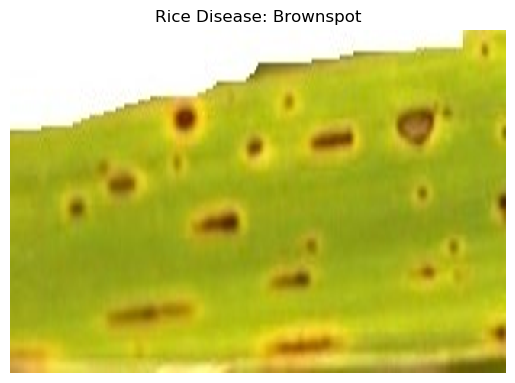

'Brownspot'

In [11]:
predict_image("testImages/1.jpg", loaded_model)

Predicted: Brownspot (73.56%)


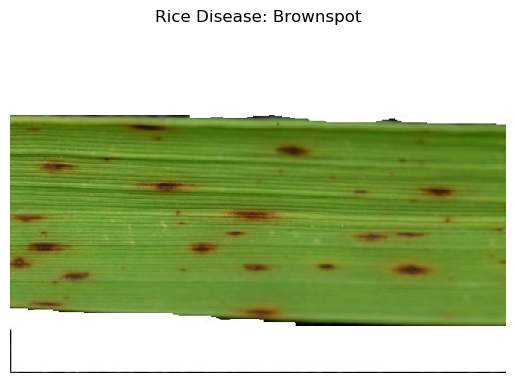

'Brownspot'

In [12]:
predict_image("testImages/6.jpg", loaded_model)

Predicted: Healthy (98.67%)


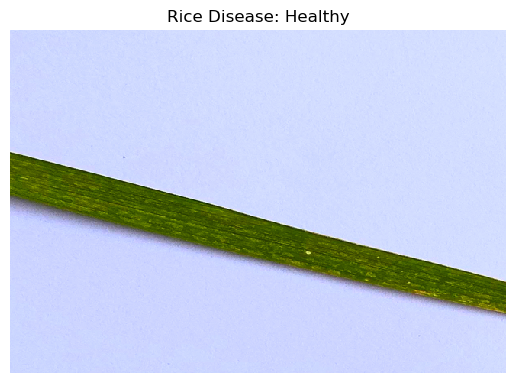

'Healthy'

In [13]:
predict_image("testImages/3.jpg", loaded_model)

Predicted: Brownspot (69.46%)


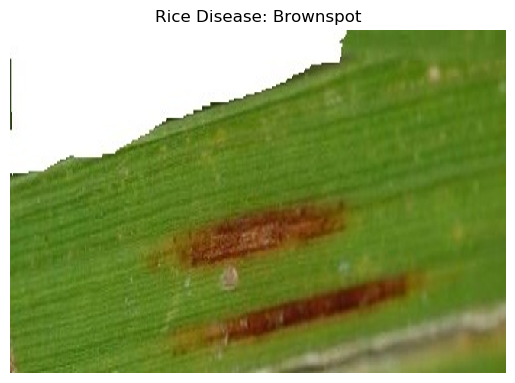

'Brownspot'

In [14]:
predict_image("testImages/5.jpg", loaded_model)

Predicted: Leafblight (93.03%)


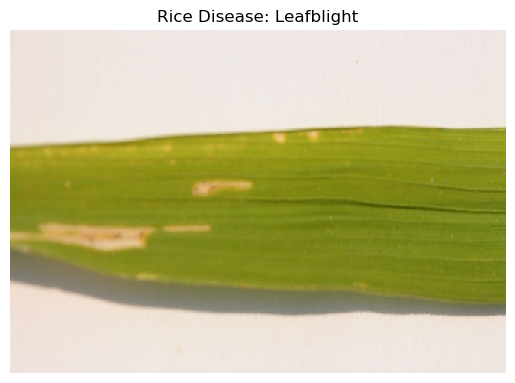

'Leafblight'

In [15]:
predict_image("testImages/7.jpg", loaded_model)

Predicted: Leafblight (55.40%)


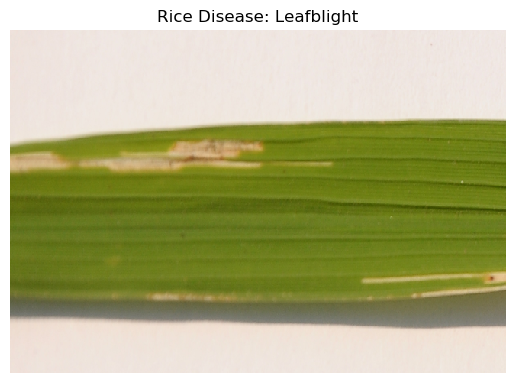

'Leafblight'

In [16]:
predict_image("testImages/8.jpg", loaded_model)